In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from tqdm import tqdm
import os, sys
import SimpleITK as sitk
from PIL import Image
import cv2
from IPython.display import clear_output
from scipy.ndimage import affine_transform

from pathlib import Path

PIPELINE_ROOT = Path('../src').resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from library.utilities.utilities_process import get_image_size, read_image
from library.utilities.utilities_registration import align_elastix

%load_ext autoreload
%autoreload 2

/home/eddyod/programming/preprocessing-pipeline/src


In [2]:
def compare_two_images(img1, img2):
    plt.figure(figsize=[20,20])
    plt.imshow(img1,cmap='Blues')
    plt.imshow(img2,alpha=0.5,cmap='Reds')

In [3]:
animal = 'CTB004'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
INPUT = os.path.join(DIR, 'CH1', 'thumbnail_aligned_iteration_1')

In [4]:
fixed_index = str(104).zfill(3)
moving_index = str(105).zfill(3) # big image
pixelType = sitk.sitkFloat32
fixed_file = os.path.join(INPUT, f'{fixed_index}.tif')
moving_file = os.path.join(INPUT, f'{moving_index}.tif')
fixed = sitk.ReadImage(fixed_file, pixelType)
moving = sitk.ReadImage(moving_file, pixelType)

In [10]:
%%time
samples = 2048 * 4
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed)
elastixImageFilter.SetMovingImage(moving)
#elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("translation"))
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))
#elastixImageFilter.AddParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.SetParameter("NumberOfResolutions", "8")
elastixImageFilter.SetParameter("MaximumNumberOfIterations", "1500")
elastixImageFilter.SetParameter("NumberOfSpatialSamples", str(samples))
elastixImageFilter.LogToConsoleOff()
#elastixImageFilter.PrintParameterMap()
elastixImageFilter.Execute()
#trans_params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
rigid_params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
#affine_params = elastixImageFilter.GetTransformParameterMap()[2]["TransformParameters"]

CPU times: user 1min 55s, sys: 1.71 s, total: 1min 57s
Wall time: 1min 17s


In [6]:
x1,y1 = trans_params
rotation,x2,y2 = rigid_params
rotation = float(rotation)
xshift = float(x1) + float(x2)
yshift = float(y1) + float(y2)
print(rotation, xshift, yshift)

-0.0212202 1.3094999999999999 -1.76898


In [20]:
xshift = 80
yshift = -200

In [ ]:
rotation, xshift, yshift = align_elastix(fixed, moving)

In [ ]:
#img = io.imread(fixed_file)
#compare_two_images(img, moving_resampled)

In [21]:
width, height = get_image_size(moving_file)
center = np.array([width, height]) / 2

#rotation, xshift, yshift = np.array([rotation, xshift, yshift]).astype(np.float16)
center = np.array(center).astype(np.float16)
R = np.array(
    [
        [np.cos(rotation), -np.sin(rotation)],
        [np.sin(rotation), np.cos(rotation)],
    ]
)
shift = center + (xshift, yshift) - np.dot(R, center)
Trigid = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
print(Trigid)

[[ 9.99774860e-01  2.12186075e-02  6.70470306e+01]
 [-2.12186075e-02  9.99774860e-01 -1.86769208e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
print(affine_params)
r00,r01,xshift,r10,r11,yshift = [float(a) for a in affine_params]
width, height = get_image_size(moving_file)
center = np.array([width, height]) / 2

#rotation, xshift, yshift = np.array([rotation, xshift, yshift]).astype(np.float16)
center = np.array(center).astype(np.float16)
R = np.array(
    [
        [r00, r01],
        [r10, r11],
    ]
)
shift = center + (xshift, yshift) - np.dot(R, center)
Taffine = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
print(Taffine)

In [ ]:
transform_parameters = np.array(affine_params, dtype=float).reshape(2,3)
affine_rotation = np.vstack([transform_parameters, [0, 0, 1]])
#Taffine = np.linalg.inv(affine_rotation)
Taffine = affine_rotation

In [22]:
im1 = Image.open(moving_file)
im2 = im1.transform((im1.size), Image.Transform.AFFINE, Trigid.flatten()[:6], resample=Image.Resampling.NEAREST)
rigidimg = np.array(im2)
del im1, im2
#im1 = Image.open(moving_file)
#im2 = im1.transform((im1.size), Image.Transform.AFFINE, Taffine.flatten()[:6], resample=Image.Resampling.NEAREST)
#affineimg = np.array(im2)
#del im1, im2

In [ ]:
img = io.imread(moving_file)
affineimg = affine_transform(img, Trigid)

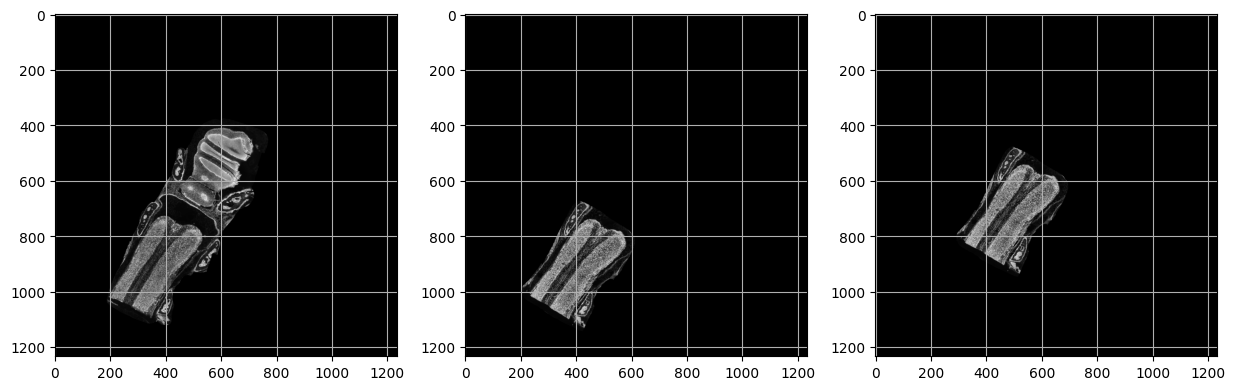

In [23]:
#fixed_index = str(105).zfill(3)
#moving_index = str(106).zfill(3) big image
img = io.imread(moving_file)
fig, ax = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].imshow(sitk.GetArrayFromImage(fixed), cmap="gray")
ax[1].imshow(rigidimg, cmap="gray")
ax[2].imshow(img, cmap="gray")

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.title('fixed image')
plt.grid()
plt.imshow(sitk.GetArrayFromImage(fixed), cmap='gray')

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.title('result image')
plt.grid()
plt.imshow(sitk.GetArrayFromImage(resultImage), cmap='gray')

In [ ]:
dimension = 2        
offset = [2]*dimension # use a Python trick to create the offset list based on the dimension
translation = sitk.TranslationTransform(dimension, offset)
print(translation)

In [ ]:
R,x,y

In [ ]:
point = [10, 11]
rotation2D = sitk.Euler2DTransform()
rotation2D.SetTranslation((x,y))
rotation2D.SetAngle(R)
print(f'original point: {point}')
transformed_point = rotation2D.TransformPoint(point)
translation_inverse = rotation2D.GetInverse()
print(f'transformed point: {transformed_point}')
print(f'back to original: {translation_inverse.TransformPoint(transformed_point)}')

In [ ]:
moving_resampled = sitk.Resample(moving, fixed, final_transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.grid()
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.grid()
plt.title('resampled image')

fig = plt.figure(figsize=(15, 8))
plt.title('moving image')
plt.grid()
plt.imshow(sitk.GetArrayViewFromImage(moving), cmap='gray')
    